# Pengu Pairs

Logical steps in a pairs trading process:<br><br>

1. Find cointegrated time-series within the ASX 300 (by using the Engle-Granger Test: Looks for unit roots in the residuals of a linear regression) <br> <br> *P.S. Must decide whether you want to do this for log prices or regular prices*

2. Using the pairs that are classified as cointegrated, map a linear combination/relationship to find the 'coefficient' for the pair - To understand what the 'hedge ratio' is

3. If they come out having p-value less than 0.01 or 0.05 in a cointegration test, validate it by using the 'check_station' function - dicky fuller test to test stationarity

4. **Repeat steps 1 --> 4 for: <br><br> a) different intervals (minutes, 10 minutes, 15 minutes, 30 minutes, 45 minutes, 60 minutes, 2 hours?, daily, weekly etc.) <br><br>and,<br><br> b) For different time periods e.g. 2010-2011, 2015-2016 ....**

In [135]:
import numpy as np
import pandas as pd
import hvplot.pandas
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Ridge

import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import holoviews as hv


https://blog.quantinsti.com/pairs-trading-basics/
https://blog.quantinsti.com/selection-pairs-statistical-arbitrage-project-divyant-agarwal/

https://www.quantconnect.com/learning/articles/investment-strategy-library/optimal-pairs-trading

https://www.quantconnect.com/learning/articles/investment-strategy-library/intraday-dynamic-pairs-trading-using-correlation-and-cointegration-approach

## Statistical Arb, Pairs Trading, Mean-Reversion:

##### In order to understand pairs trading, we need to understand three mathematical concepts:
Stationarity, 
Integration, and 
Cointegration

<span style="color:blue"> *The input to this function "data" is simply a dataframe full of securities which you would like the test the "pair" effectiveness for. It outputs a matrix of p-values, the scores and then finally those that are deemed pairs* </span>

Import data and extract tickers:

In [2]:
asx = pd.read_csv('asx_200MC.csv')
master_df = asx.dropna()
top_150 = master_df.iloc[:149,:]
master_df.tail()

,ASX code,Company name,Listing date,GICs industry group,Market Cap
535,BMN,BANNERMAN ENERGY LTD,28/4/05,Energy,203941944.0
536,CLV,CLOVER CORPORATION LIMITED,30/11/99,Materials,203739196.0
537,GVF,GLOBAL VALUE FUND LIMITED,21/7/14,Not Applic,202863819.0
538,ACF,ACROW FORMWORK AND CONSTRUCTION SERVICES LIMITED,27/6/08,Capital Goods,201689893.0
539,CU6,CLARITY PHARMACEUTICALS LTD,25/8/21,"Pharmaceuticals, Biotechnology & Life Sciences",200433930.0


In [3]:
#only need tickers
tickers = master_df['ASX code'].to_list()
tickers = tickers[0:150]

Extract data from yahoo fin:

In [4]:
df = yf.download(tickers, start = '2010-01-31')

[*********************100%***********************]  150 of 150 completed

29 Failed downloads:
- ANN: No data found for this date range, symbol may be delisted
- A2M: No timezone found, symbol may be delisted
- SQ2: No timezone found, symbol may be delisted
- AFI: No timezone found, symbol may be delisted
- TCL: No timezone found, symbol may be delisted
- STO: No data found for this date range, symbol may be delisted
- MTS: No data found for this date range, symbol may be delisted
- MPL: No data found for this date range, symbol may be delisted
- CHC: No data found for this date range, symbol may be delisted
- ARG: No data found for this date range, symbol may be delisted
- GQG: Period 'max' is invalid, must be one of ['1d', '5d']
- COH: No data found for this date range, symbol may be delisted
- SGM: No data found for this date range, symbol may be delisted
- AKE: No timezone found, symbol may be delisted
- SSR: No data found for this date range, symbol may be delisted
- JBH: Period '

Show data:

In [5]:
prices = df['Adj Close'].dropna(axis = 1)
#prices = np.log(prices)
prices.tail(1)

,AGG,AIA,ALL,ALX,AMP,APA,ASX,AUB,BEN,BHP,...,NWL,ORA,ORI,PRU,RIO,RMD,SOL,VEA,WDS,WOR
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-28 00:00:00-04:00,98.93,61.349998,106.339996,188.229996,299.350006,35.900002,7.61,35.130001,26.370001,59.639999,...,11.79,83.610001,24.4,79.400002,66.059998,213.089996,4.18,43.91,22.110001,62.950001


#### Function allows us to extract a matrix of the 'scores' of the cointegration, the p-values and the actual pairs as tuples

In [6]:
def find_cointegrated_pairs1(data):
    n = data.shape[1]
    keys = data.keys()
    pairs = []
    pvalues = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            pvalue = result[1]

            if pvalue < 0.01:
                pairs.append((keys[i], keys[j]))
                pvalues.append(pvalue)

    pairs_pvalues_df = pd.DataFrame({'Pairs': pairs, 'PValues': pvalues})
    return pairs_pvalues_df

### These pairs are really well tested on a daily basis. Since 2010, they have been cointegrated with a confidence of 99%. This is 252 x 13 years almost of data that validates this

In [7]:
pairs = find_cointegrated_pairs1(prices)
pairs = pairs.sort_values(by ='PValues')

<AxesSubplot:title={'center':'P-Values for the Pairs that have been detected based on a threshold'}, xlabel='Pairs'>

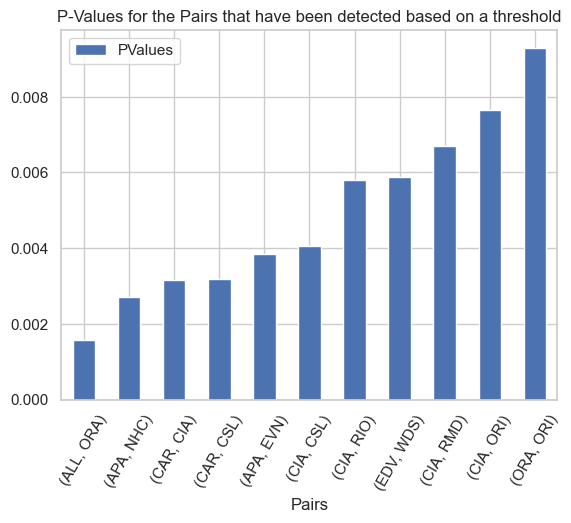

In [8]:
pairs.plot.bar(x = 'Pairs', y = 'PValues', rot = 60, title = 'P-Values for the Pairs that have been detected based on a threshold')

- The possible number of pairs given "n" number of assets is equal to the combination formula: <br><br> C(n,k) = n! / (k! * (n-k)!)<br><br> - Where k is number of stocks in each pair (2 for us)

In [9]:
n = len(prices.columns)
k = 2

def combination(n,k):
    comb = math.factorial(n)/(math.factorial(k) * math.factorial(n-k))
    return comb

print(f'The maximum possible pairs from a list of {n} stocks is {combination(n,k)}')

The maximum possible pairs from a list of 33 stocks is 528.0


### Let's see which sectors our pairs are in, are they the same?:

In [10]:
# For the purpose of loc's below:
master_df = master_df.set_index('ASX code')

In [21]:
def get_gics_sector(pair_dict, index): # The index is just to provide which pair i want the sector for
    stock_ticker = list(pair_dict)[index] #takes a list of the Pairs and maps it to it's GICS sector in the next line
    return master_df.loc[stock_ticker, 'GICs industry group']

pairs['Industry 1'] = pairs['Pairs'].map(lambda x: get_gics_sector(x, 0))
pairs['Industry 2'] = pairs['Pairs'].map(lambda x: get_gics_sector(x, 1))

pairs

,Pairs,PValues,Industry 1,Industry 2
0,"(ALL, ORA)",0.001574,Consumer Services,Materials
2,"(APA, NHC)",0.002711,Utilities,Energy
3,"(CAR, CIA)",0.003153,Media & Entertainment,Materials
4,"(CAR, CSL)",0.003196,Media & Entertainment,"Pharmaceuticals, Biotechnology & Life Sciences"
1,"(APA, EVN)",0.003844,Utilities,Materials
5,"(CIA, CSL)",0.004043,Materials,"Pharmaceuticals, Biotechnology & Life Sciences"
7,"(CIA, RIO)",0.005791,Materials,Materials
9,"(EDV, WDS)",0.005889,Consumer Staples Distribution & Retail,Energy
8,"(CIA, RMD)",0.006701,Materials,Health Care Equipment & Services
6,"(CIA, ORI)",0.007645,Materials,Materials


* #### As seen above, the most cointegrated stocks aren't neccessarily in the exact same sector! 

#### Make a df with prices only associated with the paurs:

In [34]:
#Get a list of all the tickers we care about (i.e., those in our pairs DataFrame)
tickers_to_keep = set(pair[0] for pair in pairs['Pairs']) | set(pair[1] for pair in pairs['Pairs'])

# Only keep columns with relevant tickers and create new DataFrame
relevant_prices_df = prices.loc[:, prices.columns.isin(tickers_to_keep)]
relevant_prices_df.columns

Index(['ALL', 'APA', 'CAR', 'CIA', 'CSL', 'EDV', 'EVN', 'NHC', 'ORA', 'ORI',
       'RIO', 'RMD', 'WDS'],
      dtype='object')

# <font color='green'> Visualising the Pairs Prices </font>

## Price plots since 2010:

In [113]:
# Index from 1
ret_2010 = relevant_prices_df.pct_change()
#Changing data to all start from 1
cum_prod_2010 = (1+ret_2010).cumprod()

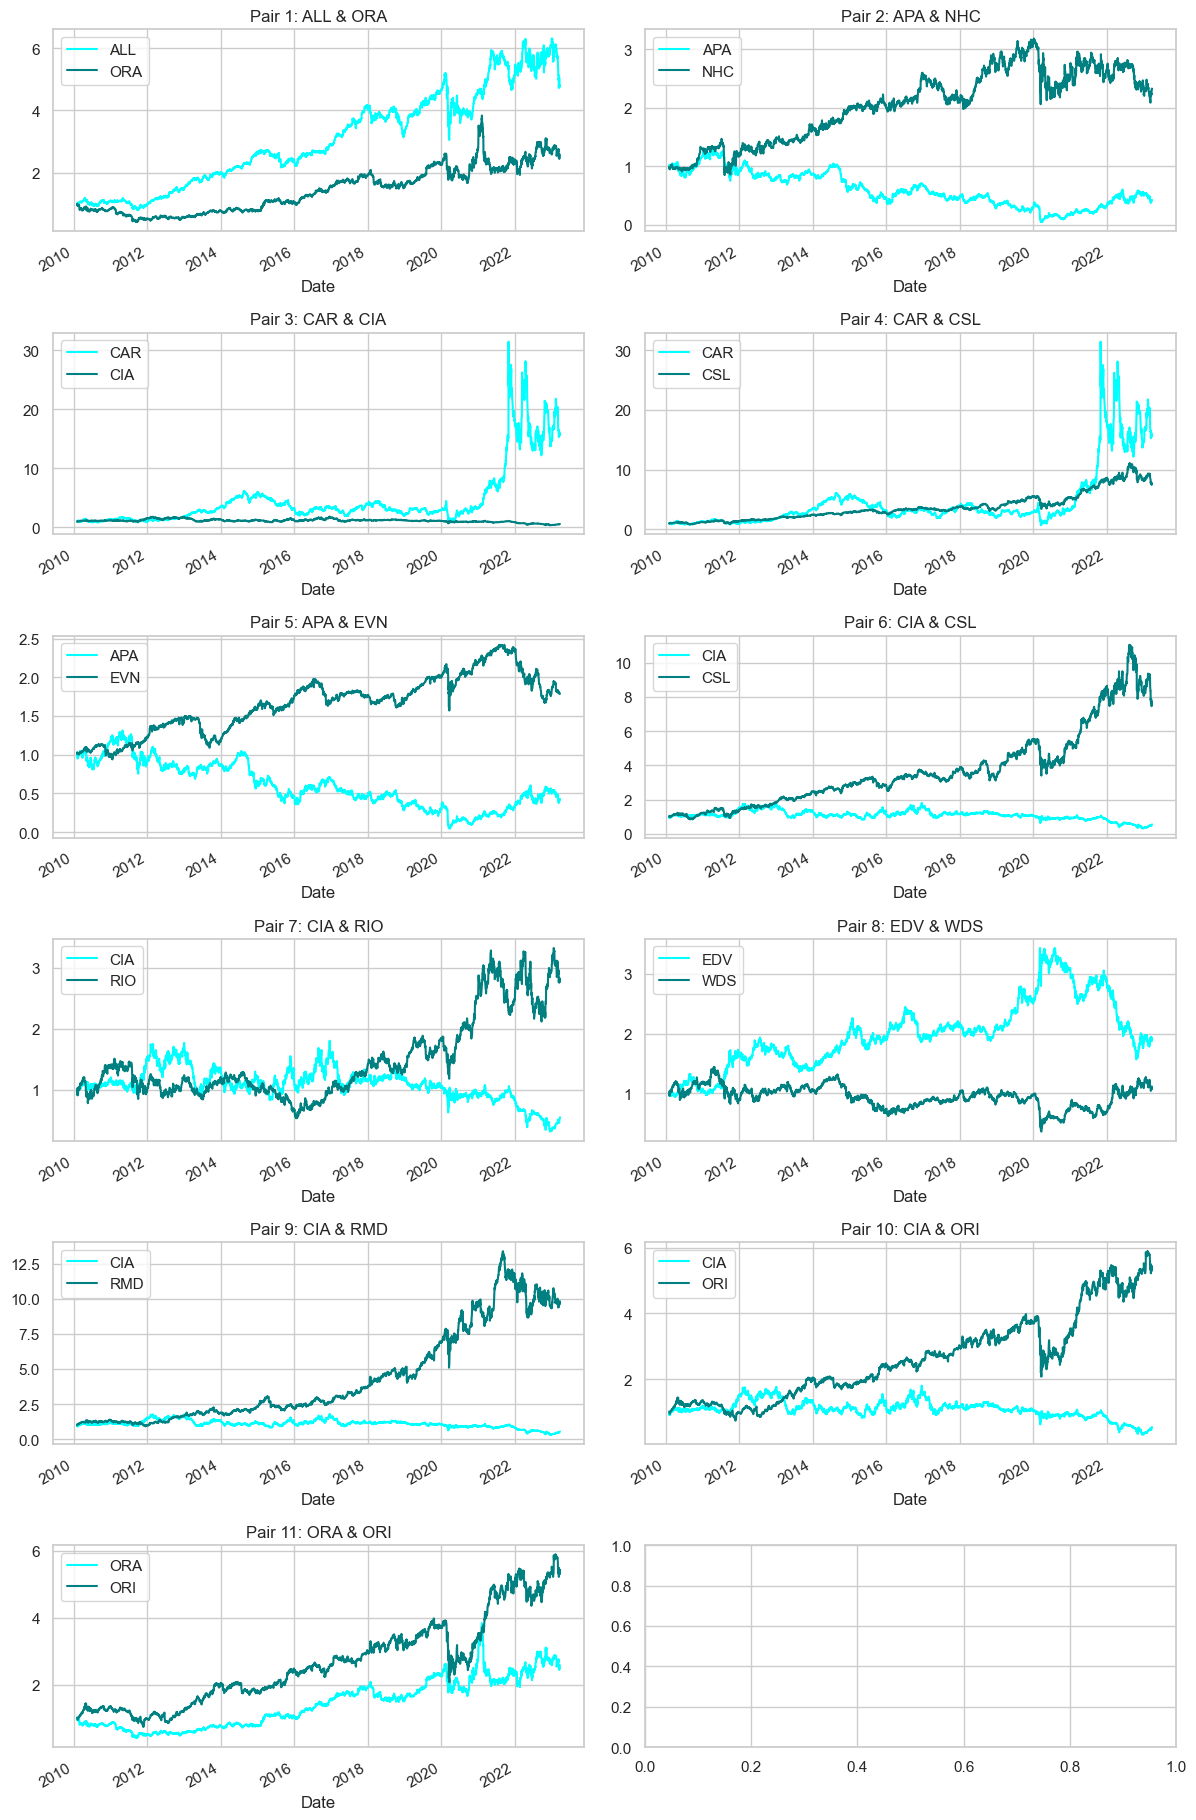

In [114]:
num_pairs = len(pairs['Pairs'])
num_rows = math.ceil(num_pairs / 2)

# Create unique plot for each pair
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 1.67*len(pairs['Pairs'])))
for i, pair in enumerate(pairs['Pairs']):
    tickers = list(pair)
    plot_df = cum_prod_2010.loc[:, tickers]
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index][col_index]
    plot_df.plot(ax=ax, title=f"Pair {i+1}: {tickers[0]} & {tickers[1]}", color=['aqua', 'teal'])
plt.tight_layout()

## Since 2022

In [115]:
# Clean data for 2022 to now
relevant_prices_df1 = relevant_prices_df.iloc[-310:,:]
ret_2022 = relevant_prices_df1.pct_change()
#Changing data to all start from 1
cum_prod_2022 = (1+ret_2022).cumprod()

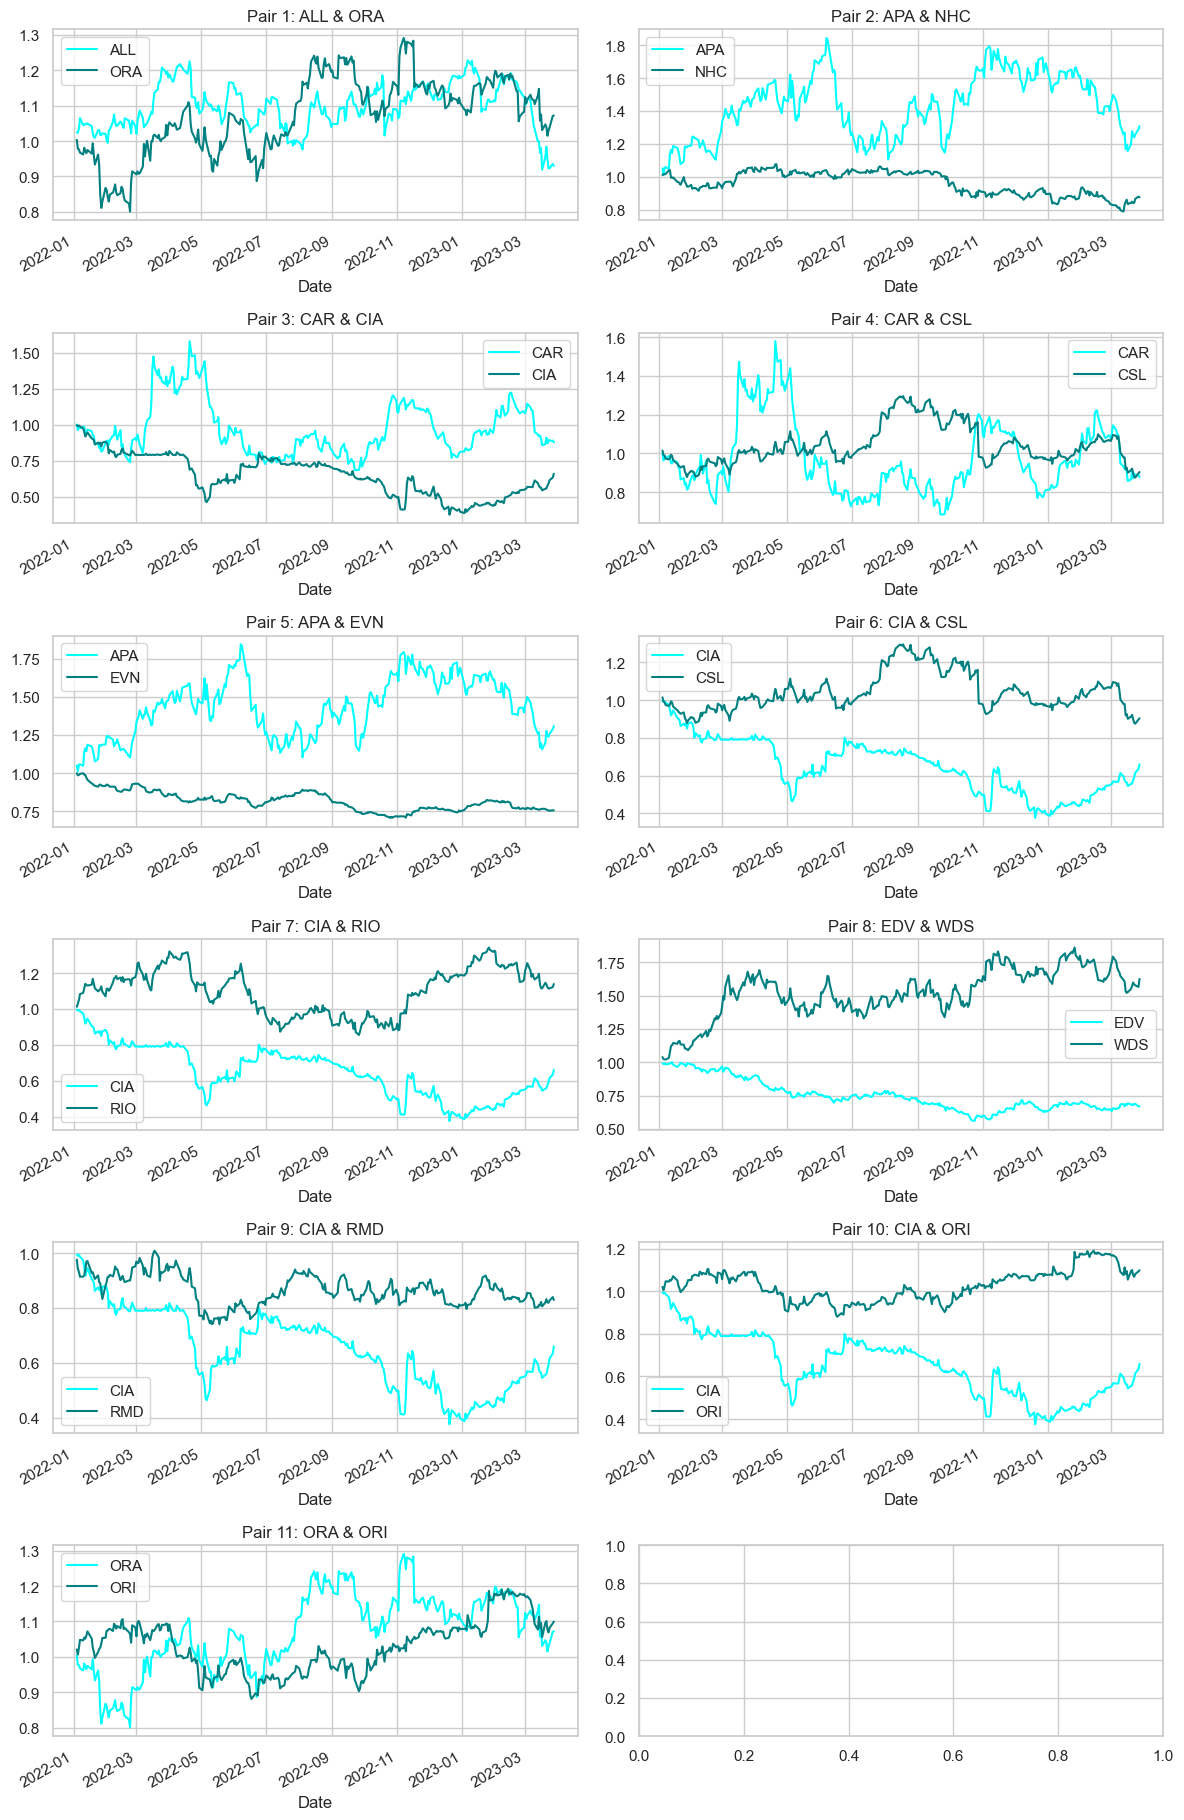

In [116]:
num_pairs = len(pairs['Pairs'])
num_rows = math.ceil(num_pairs / 2)

# Create unique plot for each pair
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 1.67*len(pairs['Pairs'])))
for i, pair in enumerate(pairs['Pairs']):
    tickers = list(pair)
    plot_df = cum_prod_2022.loc[:, tickers]
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index][col_index]
    plot_df.plot(ax=ax, title=f"Pair {i+1}: {tickers[0]} & {tickers[1]}", color=['aqua', 'teal'])
plt.tight_layout()

# <font color='green'> Hedge Ratio / Linear Combination + Spread</font>

In [118]:
# Only keep columns with relevant tickers and create new DataFrame
display(relevant_prices_df)
display(pairs['Pairs'])

,ALL,APA,CAR,CIA,CSL,EDV,EVN,NHC,ORA,ORI,RIO,RMD,WDS
Date,,,,,,,,,,,,,
2010-02-01 00:00:00-05:00,22.252220,83.869499,11.370000,6.48,28.455296,46.955822,5.506194,25.115040,32.406006,4.491925,23.405907,21.947077,19.869223
2010-02-02 00:00:00-05:00,22.675724,85.695946,11.430000,6.28,28.597401,47.067135,5.569907,24.944422,32.387779,4.579673,23.890741,22.262617,20.469248
2010-02-03 00:00:00-05:00,22.163065,84.623009,11.240000,6.11,29.826220,46.229267,5.674569,24.446207,32.487972,4.496105,23.252981,22.241297,20.328949
2010-02-04 00:00:00-05:00,21.316069,80.986473,10.490000,5.90,29.784430,47.330795,5.642709,24.302896,30.657299,4.391640,21.855110,21.716820,19.248980
2010-02-05 00:00:00-05:00,21.479523,80.593361,10.560000,6.04,28.630842,47.447975,5.592654,24.391623,30.976065,4.362390,22.123581,23.409653,19.005455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-22 00:00:00-04:00,108.529999,34.349998,176.149994,3.10,217.809998,90.459999,9.880000,55.810001,79.160004,23.900000,65.050003,210.779999,21.740000
2023-03-23 00:00:00-04:00,105.580002,34.009998,181.070007,3.18,212.960007,89.910004,9.830000,56.020000,80.330002,23.719999,64.599998,210.589996,21.549999
2023-03-24 00:00:00-04:00,105.589996,34.509998,179.699997,3.31,212.050003,90.739998,9.820000,57.590000,80.980003,24.010000,64.669998,212.580002,21.450001


0     (ALL, ORA)
2     (APA, NHC)
3     (CAR, CIA)
4     (CAR, CSL)
1     (APA, EVN)
5     (CIA, CSL)
7     (CIA, RIO)
9     (EDV, WDS)
8     (CIA, RMD)
6     (CIA, ORI)
10    (ORA, ORI)
Name: Pairs, dtype: object

## Calc the Rolling 30 day beta coefficients:

In [145]:
rolling_betas = []

# Iterate through rows of df2 and extract ticker pairs
for i, row in pairs.iterrows():
    
    # Extract ticker symbols
    ticker_1, ticker_2 = row['Pairs']
    
    # Select columns from relevant_prices_df using ticker symbols and create new dataframe with only two columns
    prices_df = relevant_prices_df[[ticker_1, ticker_2]]
    
    # Apply rolling window to new dataframe with a size of 30 days (30 rows)
    window_size = 30
    rolling_prices_df = prices_df.rolling(window=window_size)


    # Perform linear regression and extract beta parameter for each window
    rolling_betas_pair = []
    lr = LinearRegression()
    for j, window in enumerate(rolling_prices_df):
        if j >= window_size - 1:
            x = window[ticker_1].values.reshape(-1, 1)
            y = window[ticker_2].values.reshape(-1, 1)
            
            lr.fit(x,y)
            beta_val = lr.coef_[0]
            
            # Store beta value a dictionary
            rolling_betas_dict = {'Pair': row['Pairs'], 'Beta_Value': beta_val}
             
             # Append the dictionary to the list of betas 
            rolling_betas_pair.append(rolling_betas_dict)


    rolling_betas.extend(rolling_betas_pair)
    # Create pandas DataFrame from list of betas
    named_betas = pd.DataFrame(rolling_betas)

### Clean the Beta's from "long" data to usable data using this loop:

In [219]:
# Use groupby() to group the beta values by Pair
grouped_betas = named_betas.groupby(['Pair'])
wide_betas = pd.DataFrame(index = relevant_prices_df.iloc[window_size-1:,:].index) # Window size -1 to get the lag on the rolling_window
# Iterate through groups and add a new column for each pair of ticker symbols with corresponding beta values
for name, group in grouped_betas:
    col_name = name
    wide_betas[col_name] = list(group['Beta_Value'])

    wide_betas = wide_betas.apply(lambda x: x.astype(float))

#Print Beta's
wide_betas.head(5)

,"(ALL, ORA)","(APA, EVN)","(APA, NHC)","(CAR, CIA)","(CAR, CSL)","(CIA, CSL)","(CIA, ORI)","(CIA, RIO)","(CIA, RMD)","(EDV, WDS)","(ORA, ORI)"
Date,,,,,,,,,,,
2010-03-15 00:00:00-04:00,-1.545320,0.010117,0.065332,-0.122711,-0.185195,1.931998,0.607138,2.952566,2.656597,-0.620159,-0.088314
2010-03-16 00:00:00-04:00,-1.506608,0.009890,0.063226,-0.131426,-0.212887,2.080448,0.620955,2.992319,2.692536,-0.549694,-0.094910
2010-03-17 00:00:00-04:00,-1.487925,0.010787,0.057972,-0.140592,-0.265429,2.192133,0.646793,3.090161,2.679219,-0.486922,-0.105105
2010-03-18 00:00:00-04:00,-1.425571,0.010824,0.057752,-0.128583,-0.225069,2.393170,0.673710,3.163774,2.658535,-0.450167,-0.115713
2010-03-19 00:00:00-04:00,-1.499319,0.011371,0.055263,-0.163338,-0.265209,2.712945,0.707855,3.078580,2.523354,-0.282226,-0.117468


### Add to existing DF:

In [222]:
#find average "30 day" beta
mean_beta = wide_betas.mean()

# Add to pairs DF
pairs['Hedge Ratio'] = pairs['Pairs'].map(mean_beta) # SYNTAX IS: New column = OG_DF[index of whatever e.g. Tickers].map(Dictionary or wherever the data you want is)
pairs

,Pairs,PValues,Industry 1,Industry 2,coef,Hedge Ratio
0,"(ALL, ORA)",0.001574,Consumer Services,Materials,0.638625,0.255981
2,"(APA, NHC)",0.002711,Utilities,Energy,-0.527603,0.145210
3,"(CAR, CIA)",0.003153,Media & Entertainment,Materials,-0.019363,0.041853
4,"(CAR, CSL)",0.003196,Media & Entertainment,"Pharmaceuticals, Biotechnology & Life Sciences",0.944231,0.613946
1,"(APA, EVN)",0.003844,Utilities,Materials,-0.073418,-0.001516
5,"(CIA, CSL)",0.004043,Materials,"Pharmaceuticals, Biotechnology & Life Sciences",-26.692209,2.560260
7,"(CIA, RIO)",0.005791,Materials,Materials,-6.339312,0.850923
9,"(EDV, WDS)",0.005889,Consumer Staples Distribution & Retail,Energy,-0.104617,-0.063950
8,"(CIA, RMD)",0.006701,Materials,Health Care Equipment & Services,-29.543056,1.279491
6,"(CIA, ORI)",0.007645,Materials,Materials,-2.217436,0.335763


In [250]:
regression_prices

,ALL,APA,CAR,CIA,CSL,EDV,EVN,NHC,ORA,ORI,RIO,RMD,WDS
Date,,,,,,,,,,,,,
2010-03-15 00:00:00-04:00,23.125460,85.442062,10.740000,6.97,31.583979,46.246838,5.678994,24.261944,27.076424,5.099108,25.404783,25.852951,22.058533
2010-03-16 00:00:00-04:00,23.192757,85.712349,10.840000,7.00,31.852707,46.774162,5.660553,24.261944,27.414759,5.103350,25.904131,26.010719,22.047823
2010-03-17 00:00:00-04:00,23.379673,86.965492,10.580000,6.98,32.071045,46.756580,5.683605,24.562231,27.963423,5.213647,26.222933,26.351843,22.615761
2010-03-18 00:00:00-04:00,23.461910,84.729507,11.490000,7.00,31.852707,46.545666,5.715874,24.132280,27.442198,5.222130,26.014967,26.735607,22.744349
2010-03-19 00:00:00-04:00,23.372196,83.279816,10.800000,6.98,31.558783,46.938210,5.702040,24.343840,26.692354,5.196679,25.349934,26.513882,22.530029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-22 00:00:00-04:00,108.529999,34.349998,176.149994,3.10,217.809998,90.459999,9.880000,55.810001,79.160004,23.900000,65.050003,210.779999,21.740000
2023-03-23 00:00:00-04:00,105.580002,34.009998,181.070007,3.18,212.960007,89.910004,9.830000,56.020000,80.330002,23.719999,64.599998,210.589996,21.549999
2023-03-24 00:00:00-04:00,105.589996,34.509998,179.699997,3.31,212.050003,90.739998,9.820000,57.590000,80.980003,24.010000,64.669998,212.580002,21.450001


In [246]:
regression_prices = relevant_prices_df.iloc[29:,:]
regression_prices.index = pd.to_datetime(regression_prices.index)
type(wide_betas.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [257]:
spreads = {}

for pair in pairs['Pairs']:
    stock1, stock2 = pair
    
    # Get price data for both stocks
    prices1 = regression_prices[stock1]
    prices2 = regression_prices[stock2]
    
    # Get rolling beta coefficients for this pair
    # betas = wide_betas.loc[pair]
    
#     # Calculate spread using equation from prompt
#     spread = prices1 - (betas * prices2)
    
#     # Add calculated series to dictionary of spreads
#     spreads[pair] = spread

# # Create DataFrame from dictionary of spreads 
# df_spread_pairs = pd.DataFrame(spreads)

In [15]:
# Spread scaled by the beta
spread = S2 - beta * S1 # "ratio"

#Create DF to plot
plotter = pd.DataFrame(spread, columns = ['spread'])
plotter['mean'] = spread.mean()

# create the line graph using hvplot
plot = plotter.hvplot.line(line_color=['blue', 'red'], line_dash=['solid', 'dashed'])
plot.opts(title = 'Spread: Scaled by the coefficient', width = 800, height = 400)

#Establish plot for prices
plot_prices = prices[['AGG', 'APA']]

##OUTPUT##
print(f'Beta or "hedge ratio" is {round(beta,3)}. This essentially means, you need to lever {S2.name} by {round(beta,3)} compared to {S1.name} when trading.')


plot_prices.hvplot(line_color=['blue', 'red'], rot = 70, width = 800, height = 400, title = 'Log Price Movement', shared_axes = False, xlabel = '')

Beta or "hedge ratio" is -2.222. This essentially means, you need to lever APA by -2.222 compared to AGG when trading.


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

#### Testing for Stationarity:

In [16]:
def check_station(X, cutoff = 0.01):
    #Hypothesis_0 in adfuller is unit root exists (non-stationary) ///////  unit root = non-stationary
    #Must observe significant p-va;ue to convince ourselves series is stationary

    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print (f'p-value = {pvalue}, therefore likely stationary')
        return True
    else:
        print (f'p-value = {pvalue}, therefore likely not stationary')
        return False

Check for our data:

In [17]:
check_station(spread)

p-value = 0.001970089052101301, therefore likely stationary


True